# Integrating the HFM library into pyKasso #
C. Fandel 2020 <br>
Purpose: replace the skfmm module with the agd-hfm module to improve network generation capability

TO-DO:

*Necessary*
- [X] add cost map
- [X] make cost map reflect realistic values
- [X] add DxV and DyV (x and y components of gradient in each cell of array)
    - [X] option to calculate from DEM
        - [X] rotate DEM csv by 90 degrees
- [X] add alpha map (travel cost in same direction as gradient)
- [X] add beta map (travel cost perpendicular to gradient)
- [X] convert cost map into HFM library's input format
- [X] use the HFM library to compute travel time map and paths
- [ ] make sure GSLIB import for geology still works (probably needs to be rotated)
- [ ] allow iteration over multiple outlets
- [ ] allow assigning specific inlets to specific outlets
- [ ] add options in settings file to shuffle inlets and/or shuffle outlets
- [ ] output network in a format that can be used with SWMM: either use the geodesics and merge repeat nodes, OR revise compute_karst_map and compute_nodes_network
    - [ ] make sure all branches of network are connected to each other
    - [ ] make sure network is connected to outlet
    - [ ] for calculating conduit order: make sure directed graph matches gradient direction

*Useful (save for later)*
- [ ] add option to import orientations from GSLIB file
- [ ] label geology colorbar in show_catchment() so we know which colors correspond to karstifiable units
- [ ] replace all code_ functions with cost_ functions
- [ ] add to get, set, update, and show functions
    - [ ] topography
    - [ ] cost
- [ ] add/update plotting functions (use contourf, add legends, add options for what things to plot)
- [ ] rename X,Y indices to ix,iy to reduce confusion with grid
- [ ] add a grid function to convert indices to coordinates and vice-versa (use same as hfm built-in?)

### Issues ###
Next: convert conduits to a network?

### Setup & imports ###
Need to import a local version of pykasso be able to make and test changes.
Use one of the two methods below (but not both).
Question: Is one way better than the other in some way?

In [1]:
method = 2

#Method 1: using importlib
if method==1:
    import importlib.util
    spec = importlib.util.spec_from_file_location('pykasso', 'C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso/base.py')
    pk = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(pk)

#Method 2: setting the path variable to the path to the local version 
#This version allows reloading the module to see changes
if method==2:
    import sys
    sys.path.append('C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso') #path to local version of package
    import base as pk  #in this case, "base" is the name of the .py file with all of the pykasso functions in it

#Check that it worked:
#catchment = pk.SKS() #create a simple model
#You should see a printed statement indicating that you are using a development version of the package.
#If you do not see this statement, you are using the main version, and changes you make to the local version will have no effect.

In [89]:
#Import the rest of the modules needed:
import os            
import sys           
import importlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import karstnet as kn

#all fast-marching-related imports
import agd
from agd import Eikonal
from agd.Metrics import Riemann
#from agd.Plotting import quiver
#from agd import LinearParallel as lp
#from agd import AutomaticDifferentiation as ad
#norm_infinity = ad.Optimization.norm_infinity

#Local modules:
import importlib.util
spec = importlib.util.spec_from_file_location('swmmpy', 'C:/Users/Chloe/Documents/GitHub/gottesacker/swmmpy.py')
sp = importlib.util.module_from_spec(spec)
spec.loader.exec_module(sp)

#os.chdir('C:\\Users\\Chloe\\Documents\\GitHub\\pyKasso')
os.getcwd()

'C:\\Users\\Chloe\\Documents\\GitHub\\pyKasso\\notebooks'

### Test on built-in Betteraz system ###

CAUTION: You are using the development version of this package.


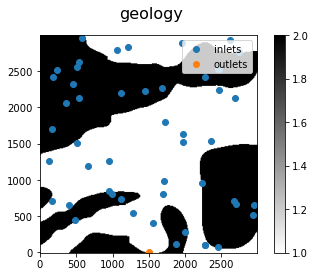

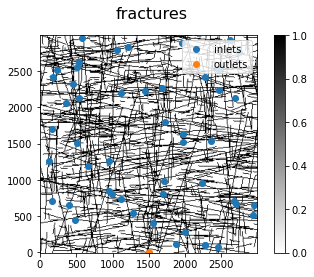

Iteration 0
Iteration 1
Iteration 2

 This network contains  6  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


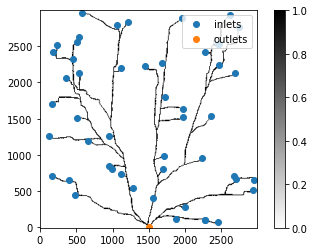

In [4]:
importlib.reload(pk)

catchment = pk.SKS('inputs/betteraz/settings_dev.yaml')
catchment.show_catchment(data='geology')
catchment.show_catchment(data='fractures')
catchment.compute_karst_network()
catchment.show()

### Simple one-valley system ###

CAUTION: You are using the development version of this package.


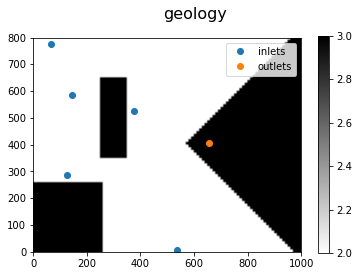

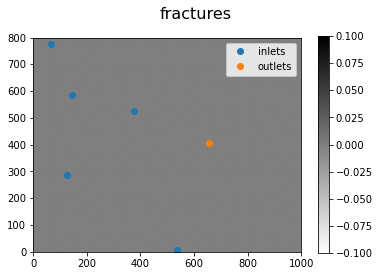

Iteration 0
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Iteration 1
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.009 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Iteration 2
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Iteration 3
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.009 s.
Field geodesicSolver defaults

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

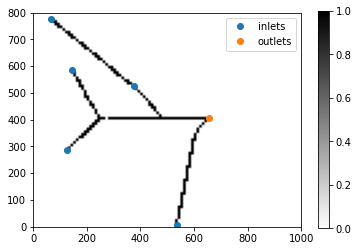

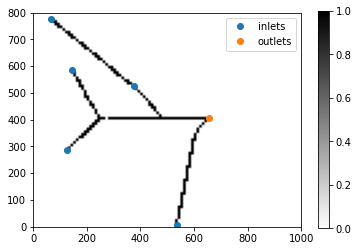

In [6]:
importlib.reload(pk)

catchment = pk.SKS('inputs/valley1/settings.yaml', rand_seed=1) #import settings and options from input folder
catchment.show_catchment(data='geology')
catchment.show_catchment(data='fractures')
catchment.compute_karst_network()
catchment.show_hfm()
catchment.show(data=catchment.maps['karst_hfm'][-1])

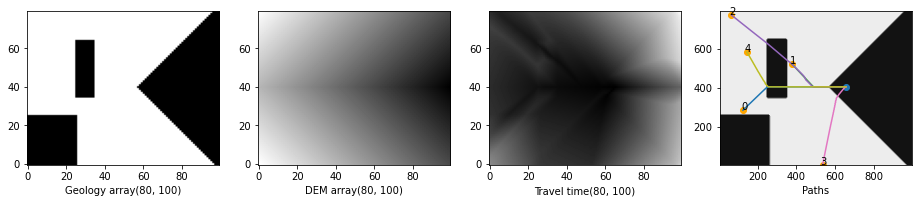

In [15]:
#Plot results:
f = plt.figure(figsize=(20,5))
f.add_subplot(151, aspect='equal')
plt.xlabel('Geology array'+str(catchment.geology.data['geology']['data'].shape))
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', cmap='gray_r') #darker=faster

f.add_subplot(152, aspect='equal')
plt.xlabel('DEM array'+str(catchment.geology.data['topography']['data'].shape))
plt.imshow(catchment.geology.data['topography']['data'], origin='lower', cmap='gray') #darker=faster

f.add_subplot(153, aspect='equal')
plt.xlabel('Travel time'+str(catchment.fastMarchingOutput['values'].shape))
plt.imshow(catchment.fastMarchingOutput['values'], origin='lower', cmap='gray') 
#plt.contourf(catchment.grid.X,catchment.grid.Y, catchment.maps['phi']) #darker=faster

f.add_subplot(154, aspect='equal')
plt.xlabel('Paths')
plt.contourf(catchment.grid.X,catchment.grid.Y, catchment.maps['alpha'][0], cmap='gray_r')
plt.scatter(catchment.inlets_hfm[:,0],  catchment.inlets_hfm[:,1], c='orange')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1])
for i,inlet in enumerate(catchment.inlets_hfm):
    plt.annotate(str(i),(inlet[0]-10,inlet[1]))        #label active inlets in order of usage
for p,paths in enumerate(catchment.conduits_hfm):
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[1,:]                               #get list of X coord
        pathY = path[0,:]
        plt.plot(pathX,pathY, c=plt.cm.get_cmap('tab10')(p/len(catchment.conduits_hfm)))

,X,Y,Z,Name,type
0,125.000000,285.000000,0,0,junction
1,255.026478,403.946422,0,1,junction
2,485.000000,405.000000,0,2,junction
3,655.000000,405.000000,0,3,outfall
4,65.000000,775.000000,0,4,junction
5,535.000000,5.000000,0,5,junction
6,645.853001,398.668816,0,6,junction
7,145.000000,585.000000,0,7,junction


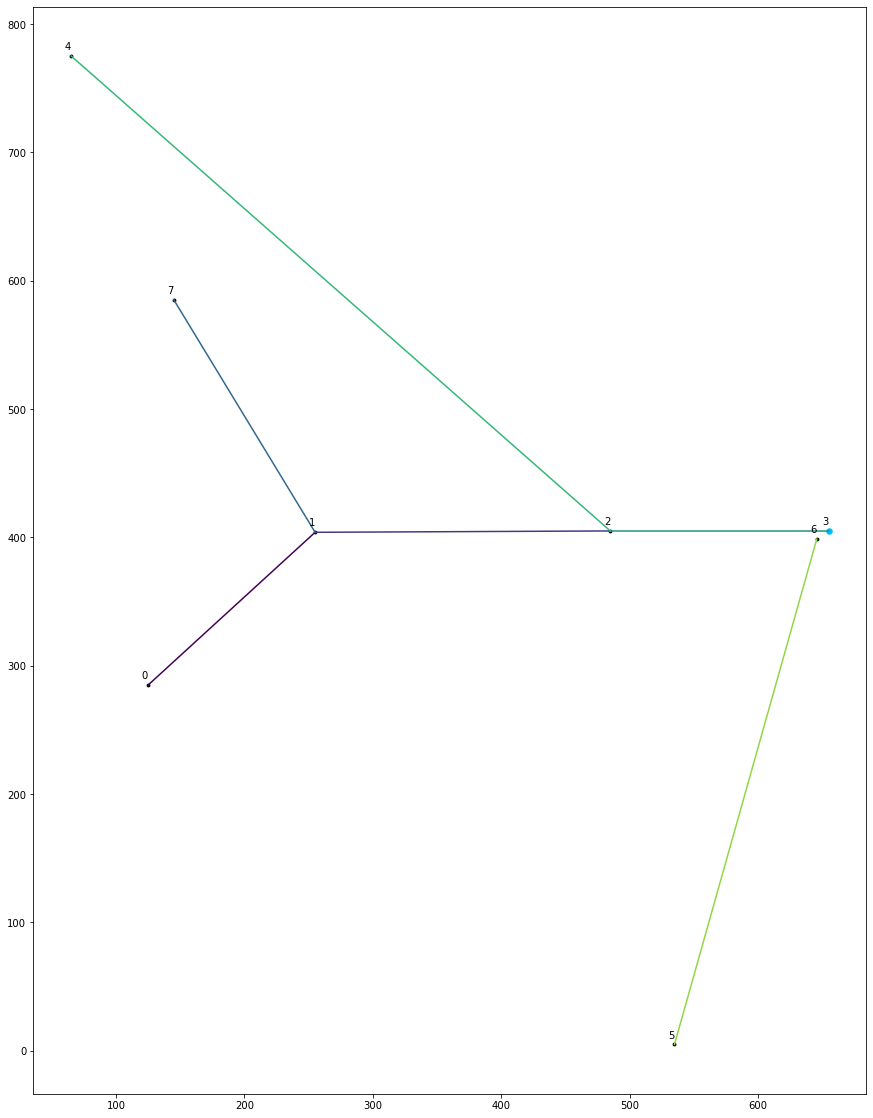

In [119]:
#Simplified network:

#Convert nodes and edges from pykasso to pandas dataframes 
nodes = catchment.karst_simulations[0].network['nodes']
nodesdf = pd.DataFrame.from_dict(nodes, orient='index', columns=['X','Y'])
edges = catchment.karst_simulations[0].network['edges']
edgesdf = pd.DataFrame(edges, columns=['InNode','OutNode'])

#################################################
#Export nodes and edges to text files
nodesdf.to_csv('outputs/valley1/valley1_nodes.dat', index=False, header=False, sep=' ')
edgesdf.to_csv('outputs/valley1/valley1_links.dat', index=False, header=False, sep=' ')

#################################################
#Convert complex network to simple network:
network = catchment.karst_simulations[0].network['karstnet']          #get karstnet network from pykasso output
nodesSimple = network.graph_simpl.nodes                 #get node indices for simple network (0-based indexing)
links = network.graph_simpl.edges                       #get edge tuples (aka links or pipes) for simple network

#Convert data to format used by swmmpy (pandas dfs):
nodes = pd.DataFrame.from_dict(network.pos3d, orient='index', columns=['X','Y','Z']) #create a df from node coord dic for entire unsimplified network
nodes = nodes[nodes.index.isin(nodesSimple)]                    #select only the nodes in the simplified network
nodes['Name'] = np.arange(0,len(nodes))                         #add name column using 0-based indices
nodes['type'] = 'junction'                                      #add column classifying all nodes as junctions for now
links = pd.DataFrame(links, columns=['In','Out'])               #convert links to df

#Replace InNode and OutNode names with re-indexed node names from simplified network:
ins, outs = [],[]                                                #create empty lists to store info
for i in range(len(links)):                                      #loop over each link index
    link = links.iloc[i]                                         #get current link
    ins.append(nodes.Name[nodes.index==link.In].values[0])       #get & store new simplified InNode index
    outs.append(nodes.Name[nodes.index==link.Out].values[0])     #same for OutNode
links['InNode'] = ins                                            #add column with simplified InNode indices
links['OutNode'] = outs                                          #add column with simplified OutNode indices
links['Name'] = links.index.values                #add name column with 0-based indices
links.drop(columns=['In','Out'], inplace=True)    #drop unneeded columns with original complex node indices
nodes.reset_index(drop=True, inplace=True)        #resart indexing from 0

#Assign outlet nodes by selecting node nearest to outlet coord and shifting it to those coordinates
springs      = pd.read_csv('inputs/valley1/outlets.txt', names=['X','Y','Z','system'], header=None, delim_whitespace=True)    #import spring location data
nodes['dist'] = ((nodes.X - springs.iloc[0,0])**2 + (nodes.Y - springs.iloc[0,1])**2)**0.5 #calculate distance to spring
nodes.loc[nodes.dist==np.min(nodes.dist), 'type'] = 'outfall'         #convert to outfall
nodes.loc[nodes.dist==np.min(nodes.dist), 'X'] = springs.iloc[0,0]    #shift X 
nodes.loc[nodes.dist==np.min(nodes.dist), 'Y'] = springs.iloc[0,1]    #shift Y
nodes.drop(labels=['dist'], axis='columns', inplace=True)    #drop  unneeded columns  

#Plot map
fromX = nodes.X.loc[links.InNode]                  #calculate coordinates for link start and end points
fromY = nodes.Y.loc[links.InNode]
toX   = nodes.X.loc[links.OutNode]
toY   = nodes.Y.loc[links.OutNode]
fig,ax = plt.subplots(figsize=(20,20))
ax.scatter(nodes.X, nodes.Y, c='k', s=8)   #plot nodes
ax.scatter(nodes[nodes.type=='outfall'].X, nodes[nodes.type=='outfall'].Y, c='deepskyblue', s=30)  #plot spring nodes in a dif color
for ind in links.index:                             #loop over link indices
    ax.plot((fromX.iloc[ind],toX.iloc[ind]),(fromY.iloc[ind],toY.iloc[ind]), c=plt.cm.get_cmap('viridis')(ind/len(links)))  #plot links
    #ax.annotate(ind, xy=(fromX.iloc[ind], fromY.iloc[ind]))
for ind in nodes.index:                         #loop over node indices
    ax.annotate(ind,xy=(nodes.X[ind]-5,nodes.Y[ind]+5))     #label nodes with index
ax.set_aspect('equal')

nodes

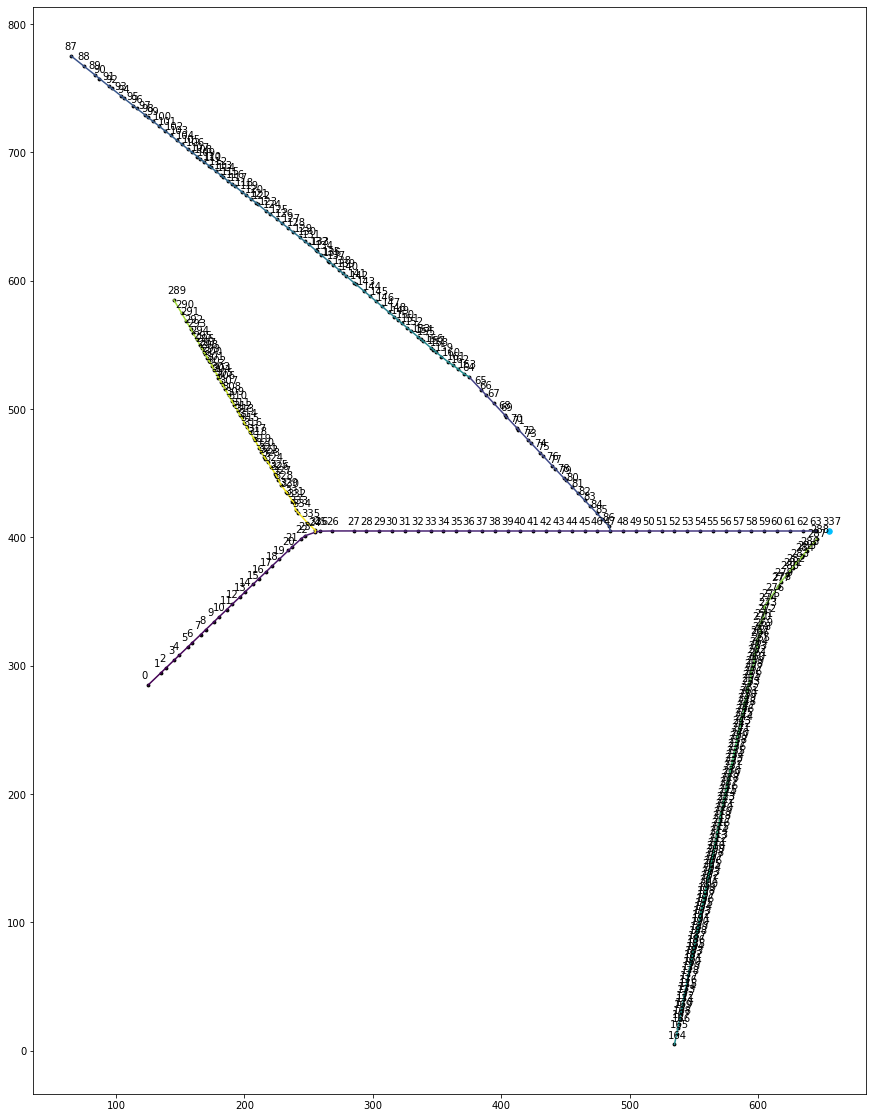

In [120]:
#Complex network:
nodes = catchment.karst_simulations[0].network['nodes']
nodes = pd.DataFrame.from_dict(nodes, orient='index', columns=['X','Y'])
edges = catchment.karst_simulations[0].network['edges']
links = pd.DataFrame(edges, columns=['InNode','OutNode'])

#Assign outlet nodes by selecting node nearest to outlet coord and shifting it to those coordinates
springs      = pd.read_csv('inputs/valley1/outlets.txt', names=['X','Y','Z','system'], header=None, delim_whitespace=True)    #import spring location data
nodes['dist'] = ((nodes.X - springs.iloc[0,0])**2 + (nodes.Y - springs.iloc[0,1])**2)**0.5 #calculate distance to spring
nodes.loc[nodes.dist==np.min(nodes.dist), 'type'] = 'outfall'         #convert to outfall
nodes.loc[nodes.dist==np.min(nodes.dist), 'X'] = springs.iloc[0,0]    #shift X 
nodes.loc[nodes.dist==np.min(nodes.dist), 'Y'] = springs.iloc[0,1]    #shift Y
nodes.drop(labels=['dist'], axis='columns', inplace=True)    #drop  unneeded columns  

#Plot map
fromX = nodes.X.loc[links.InNode]                  #calculate coordinates for link start and end points
fromY = nodes.Y.loc[links.InNode]
toX   = nodes.X.loc[links.OutNode]
toY   = nodes.Y.loc[links.OutNode]
fig,ax = plt.subplots(figsize=(20,20))
ax.scatter(nodes.X, nodes.Y, c='k', s=8)   #plot nodes
ax.scatter(nodes[nodes.type=='outfall'].X, nodes[nodes.type=='outfall'].Y, c='deepskyblue', s=30)  #plot spring nodes in a dif color
for ind in links.index:                             #loop over link indices
    ax.plot((fromX.iloc[ind],toX.iloc[ind]),(fromY.iloc[ind],toY.iloc[ind]), c=plt.cm.get_cmap('viridis')(ind/len(links)))  #plot links
    #ax.annotate(ind, xy=(fromX.iloc[ind], fromY.iloc[ind]))
for ind in nodes.index:                         #loop over node indices
    ax.annotate(ind,xy=(nodes.X[ind]-5,nodes.Y[ind]+5))     #label nodes with index
ax.set_aspect('equal')

### Run on Gottesacker 2D ###

CAUTION: You are using the development version of this package.


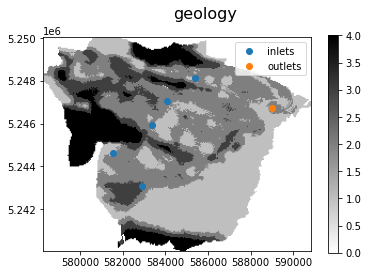

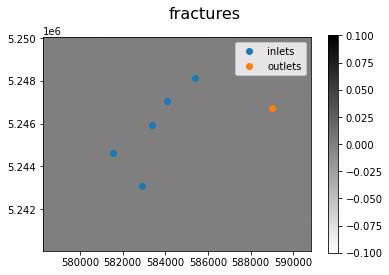

iteration 0
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.057 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
iteration 1
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.058 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
iteration 2
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.071 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
iteration 3
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.067 s.
Field geodesicSolver defaults

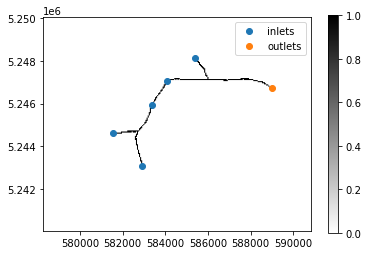

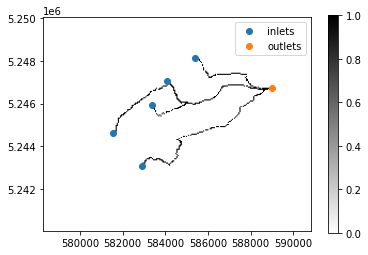

In [30]:
importlib.reload(pk)

catchment = pk.SKS('notebooks/inputs/gottesacker/settings.yaml', rand_seed=1) #import settings and options from input folder
catchment.show_catchment(data='geology')
catchment.show_catchment(data='fractures')
catchment.compute_karst_network()
catchment.show()
catchment.show_hfm()

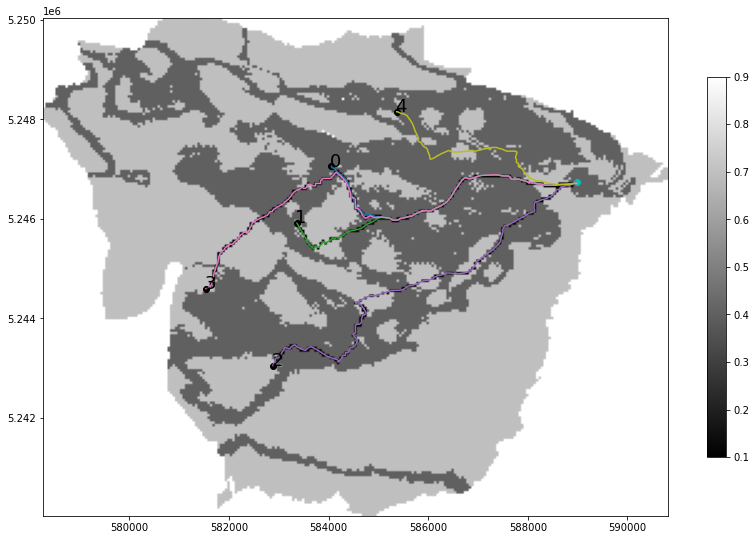

In [31]:
#Show karst in more detail:
f,ax = plt.subplots(1,1, figsize=(14,14))
#ax.grid()
#ax.scatter(catchment.grid.X, catchment.grid.Y, s=1, c='k')
#ax.scatter(catchment.grid.xlimits, catchment.grid.ylimits, s=1, c='r')

m = ax.imshow(catchment.maps['cost'][-1], extent=catchment.grid.extent, origin='lower', cmap='binary_r')
#m = ax.imshow(catchment.geology.data['topography']['data'], extent=extent, origin='lower', cmap='binary_r')
plt.colorbar(m, ax=ax, shrink=0.5)

paths = catchment.conduits_hfm
for i,iteration in enumerate(catchment.conduits_hfm):
    for path in iteration:                                  #loop over paths (one per tip/starting point)
        pathX = path[0,:]                               #get list of X coord
        pathY = path[1,:]
        ax.plot(pathX,pathY, c=plt.cm.get_cmap('tab10')(i/len(catchment.conduits_hfm)))
ax.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='c')
inlets  =  np.asarray(catchment.inlets)[:,:2]
ax.scatter(inlets[ :,0],  inlets[:,1], c='k')
for i,inlet in enumerate(catchment.inlets):
    plt.annotate(str(inlet[2]), (inlet[0]-30,inlet[1]), fontsize=18)     #label inlet iteration order


#### Original and recommended settings ####
*Velocity:* higher for easier-to-traverse fm like aquifer <br>
*Cost:* lower for easier-to-traverse fm like aquifer <br>

**Values used in HFM (for cost):**<br>
```
Ckarst          = 0.2    #travel cost in karstifiable unit (should be low)
Cnonkarst       = 0.6    #travel cost in nonkarst unit (should be high)
Cfracture       = 0.05   #travel cost in fractures
Cconduit        = 0.1    #travel cost in conduits (should be low)
Cobstacle       = 0.8    #travel cost through obstacles (should be high)
Cout            = 0.999  #travel cost in areas outside model bound (should be very high)
```
**Original values (for velocity):**
```
code aquifere   = 2 
code aquiclude  = 1 
code faults     = 4 
code fractures  = 3
code conduits   = 5 
code out        = 0.1 
```

### Inputs/outputs for fast-marching ###
For compute_time_map() using skfmm: <br>
```
self.maps['time'][iteration] = skfmm.travel_time(self.maps['phi'], self.maps['velocity'][iteration], dx=self.grid.dx, order=2)
```
- phi map - where the travel time=0, i.e. the target location(s) for the base level (and springs?) (array of 0s and 1s of dim (xres,yres))
    - from compute_phi_map(), needs:
        - outlets
- velocity map - how easy it is to travel through each cell (array of dim (xres,yres), larger values=easier to travel through) 
    - from compute_velocity_map(), needs:
       - code_aquifere
       - code_aquiclude
       - code_out
- dx - cell length in each dimension (array: [dx,dy])
- order - 1 or 2 (default), order of computational stencil to use in updating points (?)

For agd-hfm: <br>
```
hfmIn = Eikonal.dictIn({
    'model':             'Riemann3', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':              2,         #recommended setting: 2
    'exportValues':       1,         #output travel time field
    'exportGeodesicFlow': 1          #output walker paths
})
hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax],[zmin,zmax]],dims=[xres,yres,zres])
for seed in springs:
    hfmIn['seed'] = seed
    for tip in tips:
        hfmIn['tips'] = [tip]
        hfmIn['metric']    =  F
        hfmOut = hfmIn.Run()
        paths = hfmOut['geodesics']
``` 
       
- seed - coordinates of travel time=0 location, i.e. the spring the conduits are traveling to (array of [x y z])
- tips - coordinates of starting points for walkers, i.e. the inlets (array of [[x1 y1 z1] [x2 y2 z2]]
- metric - travel cost through each cell, i.e. the inverse of the velocity (array of cost values, higher=slower to travel through). If using anisotropic FM, this will include travel cost both parallel and perpendicular to the cell's gradient.
    - to calculate travel cost metric, need:
        - DxV,DyV,DzV: x and y components of gradient in each cell of array, calculate from DEM or from geologic model orientations in each cell (arrays of dim (xres,yres)).
        - alpha: travel cost in same direction as gradient (array of dim (xres,yres) of values between 0 and 1, higher=slower)
        - beta: travel cost perpendicular to gradient (same format as alpha)
- model - which fast-marching algorithm to use (string, either Riemann2, Riemann3, Isotropic2, Isotropic3).

